In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
class myDataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        point = self.X[idx]
        point = torch.from_numpy(np.asarray(point))
        point = point.to(torch.float32)
        point = torch.reshape(point, (-1,))
        
        label = self.y[idx]
        label = torch.from_numpy(np.asarray(label))
        label = label.to(torch.float32)
        label = torch.reshape(label, (-1,))
        
        return point, label

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_neurons, feature_size):
        super().__init__()
        self.n = hidden_neurons
        
        self.linear = nn.Sequential(
            nn.Linear(feature_size, self.n),
            nn.Linear(self.n,1)
        )
        
    def forward(self, x):
        return self.linear(x)

In [5]:
def data_loader(sample_size, feature_size):
    X, y = make_regression(n_samples=sample_size, n_features=feature_size, bias=0, noise=10, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    torch.manual_seed(42)

    train_dataset = myDataSet(X_train, y_train)
    test_dataset = myDataSet(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)
    
    return (train_loader, test_loader)

In [51]:
import random

def data_loader_2(sample_size, feature_size):
    X_list = []
    y_list = []
    y_list_2 = []

    for i in range(sample_size):
        x = i / 10 - sample_size / 20
        X_list.append(x)
        rd = 0
        if (random.random() <= 0.3):
            rd = 10 * random.random()
        elif (0.3 < random.random() <= 0.6):
            rd = - 10 * random.random()

        y_list.append(x**3 - 2*x**2 + 4*x + rd)
        y_list_2.append(x**3 - 2*x**2 + 4*x)
        
    plt.xlabel("X")
    plt.ylabel("y")
    plt.plot(X_list, y_list)
    plt.show()
        
    X = np.expand_dims(X_list, -1)
    y = np.expand_dims(y_list, -1)
    y_2 = np.expand_dims(y_list_2, -1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    train_dataset = myDataSet(X_train, y_train)
    test_dataset = myDataSet(X_test, y_test)

    #train_dataset = myDataSet(X, y)
    #test_dataset = myDataSet(X, y_2)

    train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)
    
    return (train_loader, test_loader)

In [52]:
import sys

def train_model(train_loader, test_loader, neuron_size, feature_size):
    loss_fn = nn.MSELoss()
    mlp = MLP(hidden_neurons=neuron_size, feature_size=feature_size)
    mlp = mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-5)
    
    last_train_loss = sys.maxsize
    current_train_loss = sys.maxsize - 10
    
    while last_train_loss - current_train_loss > 1:
        #print("Train Loss : ", current_train_loss)
        
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y_hat = mlp(x)
            loss = loss_fn(y, y_hat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        last_train_loss, current_train_loss = current_train_loss, 0
        
        with torch.no_grad():
            mlp.eval()
            for data in train_loader:
                inputs, outputs = data
                inputs = inputs.to(device)
                outputs = outputs.to(device)
                predicted_outputs = mlp(inputs)
                loss = loss_fn(predicted_outputs, outputs)
                current_train_loss += loss
        
        current_train_loss /= len(train_loader)
        
        
    total_test_loss = 0
    with torch.no_grad():
        mlp.eval()
        for data in test_loader:
            inputs, outputs = data
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            predicted_outputs = mlp(inputs)
            loss = loss_fn(predicted_outputs, outputs)
            total_test_loss += loss
    total_test_loss = total_test_loss / len(test_loader)

    return total_test_loss.detach().cpu().squeeze().numpy()

In [53]:
def train_model_fix(train_loader, test_loader, neuron_size, feature_size):
    loss_fn = nn.MSELoss()
    mlp = MLP(hidden_neurons=neuron_size, feature_size=feature_size)
    mlp = mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-5)
    epoch = 20
    
    for i in range(epoch):
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y_hat = mlp(x)
            loss = loss_fn(y, y_hat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    total_test_loss = 0
    with torch.no_grad():
        mlp.eval()
        for data in test_loader:
            inputs, outputs = data
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            predicted_outputs = mlp(inputs)
            loss = loss_fn(predicted_outputs, outputs)
            total_test_loss += loss
    total_test_loss = total_test_loss / len(test_loader)

    return total_test_loss.detach().cpu().squeeze().numpy()

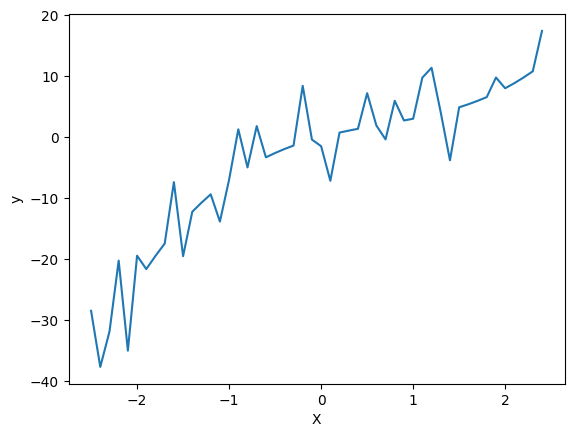

Neuron Size :  1  ; Test Loss :  156.43399
Neuron Size :  2  ; Test Loss :  135.20938
Neuron Size :  3  ; Test Loss :  33.262943
Neuron Size :  4  ; Test Loss :  33.04334
Neuron Size :  5  ; Test Loss :  32.45558
Neuron Size :  6  ; Test Loss :  32.88987
Neuron Size :  7  ; Test Loss :  32.81405
Neuron Size :  8  ; Test Loss :  32.86301
Neuron Size :  9  ; Test Loss :  35.325783
Neuron Size :  10  ; Test Loss :  35.652615
Neuron Size :  11  ; Test Loss :  32.57553
Neuron Size :  12  ; Test Loss :  33.54107
Neuron Size :  13  ; Test Loss :  34.87471
Neuron Size :  14  ; Test Loss :  34.172325
Neuron Size :  15  ; Test Loss :  32.906067
Neuron Size :  16  ; Test Loss :  35.80273
Neuron Size :  17  ; Test Loss :  33.27062
Neuron Size :  18  ; Test Loss :  33.681667
Neuron Size :  19  ; Test Loss :  33.00896
Neuron Size :  20  ; Test Loss :  34.887054
Neuron Size :  21  ; Test Loss :  35.637997
Neuron Size :  22  ; Test Loss :  34.25808
Neuron Size :  23  ; Test Loss :  33.439903
Neuron Si

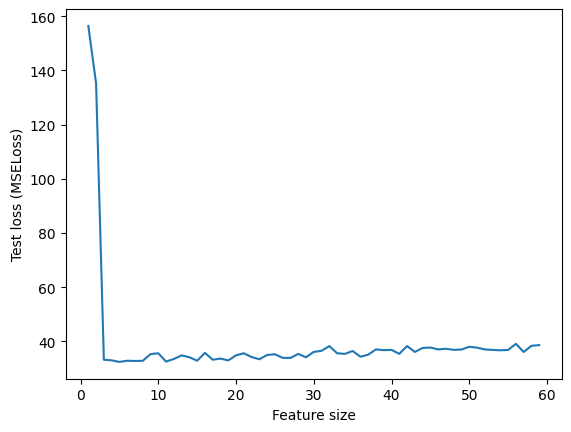

In [54]:
losses = []
n_neurons = [i for i in range(1, 60, 1)]
train_loader, test_loader = data_loader_2(50, 1)

for n in n_neurons:
    l = train_model(train_loader, test_loader, n, 1)
    print("Neuron Size : ", n, " ; Test Loss : ", l)
    losses.append(l)
    
plt.xlabel("Feature size")
plt.ylabel("Test loss (MSELoss)")
plt.plot(n_neurons, losses)
plt.show()

In [ ]:
losses = []
n_neurons = [i for i in range(5, 400, 5)]
n_sample = [i for i in range(50, 280, 10)]

for n in n_sample:
    train_loader, test_loader = data_loader(sample_size=n, feature_size=100)
    l = train_model(train_loader, test_loader, n, 100)
    print("Sample Size : ", n, " ; Test Loss : ", l)
    losses.append(l)
    
plt.xlabel("Sample size")
plt.ylabel("Test loss (MSELoss)")
plt.plot(n_sample, losses)
plt.show()

In [ ]:
losses = []
n_feature = [i for i in range(1, 200, 10)]

for n in n_feature:
    train_loader, test_loader = data_loader(sample_size=100, feature_size=n)
    l = train_model(1, train_loader, test_loader, feature_size=n)
    print("Feature Size : ", n, " ; Test Loss : ", l)
    losses.append(l)
    
plt.xlabel("Feature size")
plt.ylabel("Test loss (MSELoss)")
plt.plot(n_feature, losses)
plt.show()